# ML Models
---

## Libraries

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="muted")

import warnings 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import shap
import joblib

---
## Load data

In [157]:
# Load PCA, Normalized + One-Hotenconded
df = pd.read_csv('..\\datasets\\2. Processed Dataset\\pca_result.csv')

---
# Compute Metrics

In [158]:
def compute_metrics(y_true, y_pred):
    errors = y_pred - y_true
    bias = errors.sum()  # Sum of errors
    return {
        "BIAS": round(bias,2),
        "MAE": round(mean_absolute_error(y_true, y_pred),2),
        "RMSE": round(root_mean_squared_error(y_true, y_pred),2),
        "%RMSE": round((root_mean_squared_error(y_true, y_pred) / y_true.mean()) * 100,2),
        "R²": round(r2_score(y_true, y_pred),4)
    }

---
## Training models and Hyperparameter Tuning with Grid Search

In [ ]:
# Split of the dataset into features and target
X = df.drop(columns=['Salary'])  
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42) # 25% test

# Standardize Salary
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel() # Transformation should be fited with the complete dataset.
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Save the scaler used for Salary
joblib.dump(scaler_y, '..\\models\\salary_scaler.pkl')

# Hyperparameter grids
param_grids = {
    "Linear Regression": {},
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [2, 4, 8, 10, 20, None],
        "min_samples_split": [2, 5, 10, 20]  
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
    },
    "Neural Network": {
        'hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
}

# Initialize models
models = {
    "Linear Regression":LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Neural Network": MLPRegressor(max_iter=500, random_state=42)
}

In [160]:
# Train models with hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grids:
        search = GridSearchCV(model, param_grids[name], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        search.fit(X_train, y_train_scaled)
        best_models[name] = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:
        model.fit(X_train, y_train_scaled)
        best_models[name] = model

# Compute and display model metrics
results = {}
for name, model in best_models.items():
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    results[name] = compute_metrics(y_test, y_pred)

df_results = pd.DataFrame(results).T
df_results

Best params for Linear Regression: {}
Best params for Random Forest: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}
Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best params for Neural Network: {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}


,BIAS,MAE,RMSE,%RMSE,R²
Linear Regression,-70940.84,11362.59,16472.49,16.86,0.8922
Random Forest,91563.08,9815.12,16114.95,16.49,0.8969
XGBoost,-36244.58,10069.25,15401.40,15.76,0.9058
Neural Network,-297478.93,10704.20,15397.06,15.76,0.9058


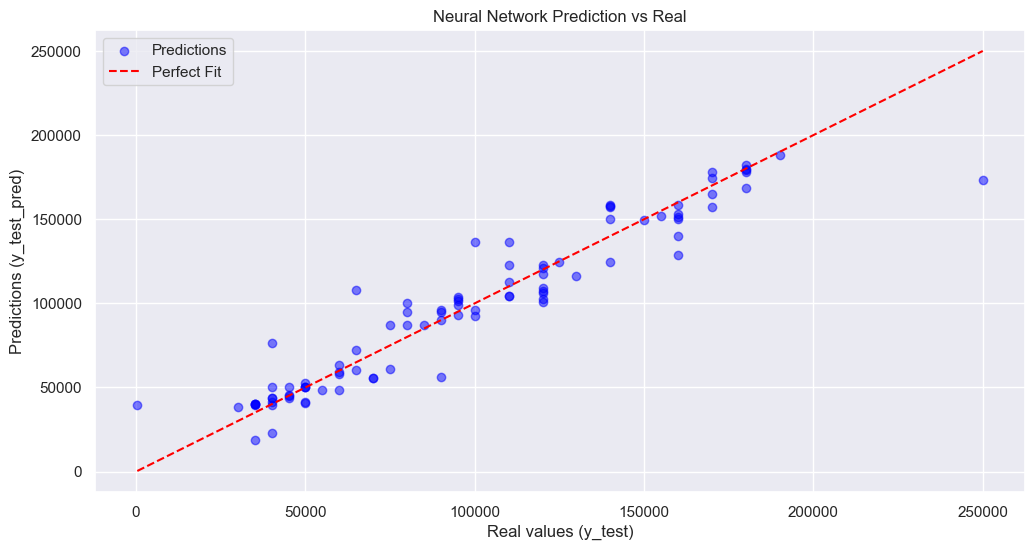

In [161]:
# Prediction for best performing model
y_test_pred_scaled = best_models["XGBoost"].predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Test vs Pred comparison
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Real values (y_test)")
plt.ylabel("Predictions (y_test_pred)")
plt.title("Neural Network Prediction vs Real")
plt.legend()
plt.show()

---
## Overfitting Evaluation

### Compare Training vs. Test Performance

In [162]:
# Evaluatiing models
def evaluate_models(models, X_train, y_train, X_test, y_test, scaler_y):
    results = []  
    for name, model in models.items():
        y_train_pred_scaled = model.predict(X_train)
        y_test_pred_scaled = model.predict(X_test)

        # Inverse scale predictions
        y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

        # Compute training and test metrics
        train_metrics = compute_metrics(y_train, y_train_pred)
        test_metrics = compute_metrics(y_test, y_test_pred)

        # Append results
        results.append({
            "Model": name,
            "Train_R²": train_metrics["R²"],
            "Test_R²": test_metrics["R²"],
            "Train_RMSE": train_metrics["RMSE"],
            "Test_RMSE": test_metrics["RMSE"],
            "Train_MAE": train_metrics["MAE"],
            "Test_MAE": test_metrics["MAE"],
            "Train_%RMSE": train_metrics["%RMSE"],
            "Test_%RMSE": test_metrics["%RMSE"]
        })

    # DataFrame
    df_results = pd.DataFrame(results)
    return df_results

# Apply this function to all trained models
df_results = evaluate_models(best_models, X_train, y_train, X_test, y_test, scaler_y)
df_results

,Model,Train_R²,Test_R²,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_%RMSE,Test_%RMSE
0,Linear Regression,0.9112,0.8922,14220.76,16472.49,10555.59,11362.59,13.99,16.86
1,Random Forest,0.9771,0.8969,7222.74,16114.95,4621.83,9815.12,7.10,16.49
2,XGBoost,0.9828,0.9058,6260.04,15401.40,4389.41,10069.25,6.16,15.76
3,Neural Network,0.9475,0.9058,10934.10,15397.06,7753.75,10704.20,10.75,15.76


### Cross-Validation

In [163]:
def cross_validate_models(models, X, y_scaled, cv=5):
    results = []
    for name, model in models.items():
        scores = cross_val_score(model, X, y_scaled, cv=cv, scoring='r2', n_jobs=-1)
        # Append results
        results.append({
            "Model": name,
            "CV_Mean_R²": round(scores.mean(), 2),
            "CV_Std_R²": round(scores.std(), 2)
        })
    # DataFrame
    df_cv_results = pd.DataFrame(results)
    return df_cv_results

# Apply this function to all trained models
df_cv_results = cross_validate_models(best_models, X, y_scaled, cv=5)
df_cv_results

,Model,CV_Mean_R²,CV_Std_R²
0,Linear Regression,0.88,0.07
1,Random Forest,0.87,0.08
2,XGBoost,0.89,0.07
3,Neural Network,0.89,0.06


In [164]:
# Bootstrap metrics and resample number
boot_metrics = {"MAE": [], "RMSE": [], "R²": []}
num_bootstrap = 1000

# Bootstrap loop for XGBoost
for _ in range(num_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
   
    y_test_sample = y_test.iloc[indices]

    y_pred_scaled = best_models["XGBoost"].predict(X_test.iloc[indices]) 
    y_pred_sample = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    boot_metrics["MAE"].append(mean_absolute_error(y_test_sample, y_pred_sample))
    boot_metrics["RMSE"].append(root_mean_squared_error(y_test_sample, y_pred_sample))
    boot_metrics["R²"].append(r2_score(y_test_sample, y_pred_sample))

ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}
ci_95


{'MAE': (np.float64(7982.492495329483), np.float64(12613.807348632812)),
 'RMSE': (np.float64(11228.224023899114), np.float64(19994.901579266036)),
 'R²': (np.float64(0.8593978498425657), np.float64(0.9449532305433284))}

---
## Feature importance and SHAP analysis for XGBoost

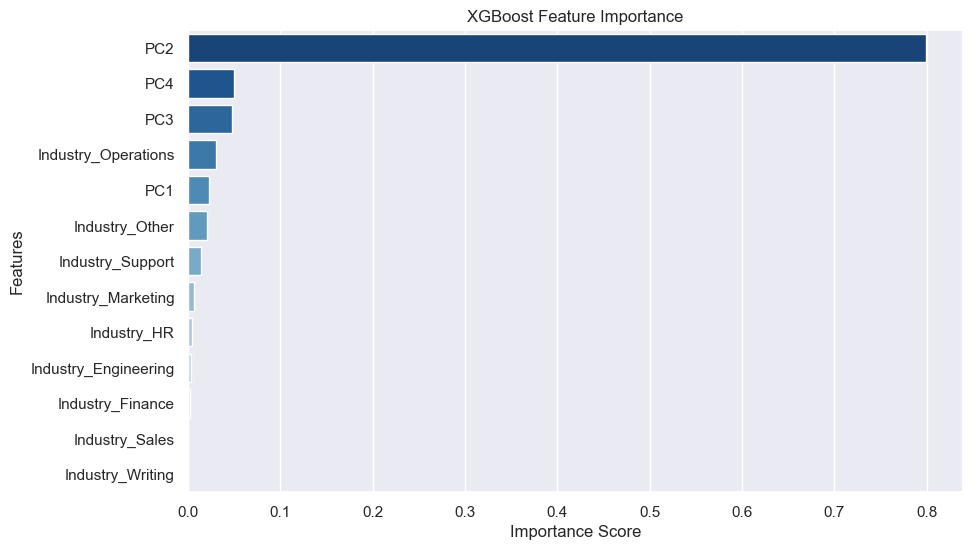

In [165]:
# Verificar si el modelo tiene feature_importances_
importance = best_models["XGBoost"].feature_importances_
features = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({"Feature": features, "Importance": importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


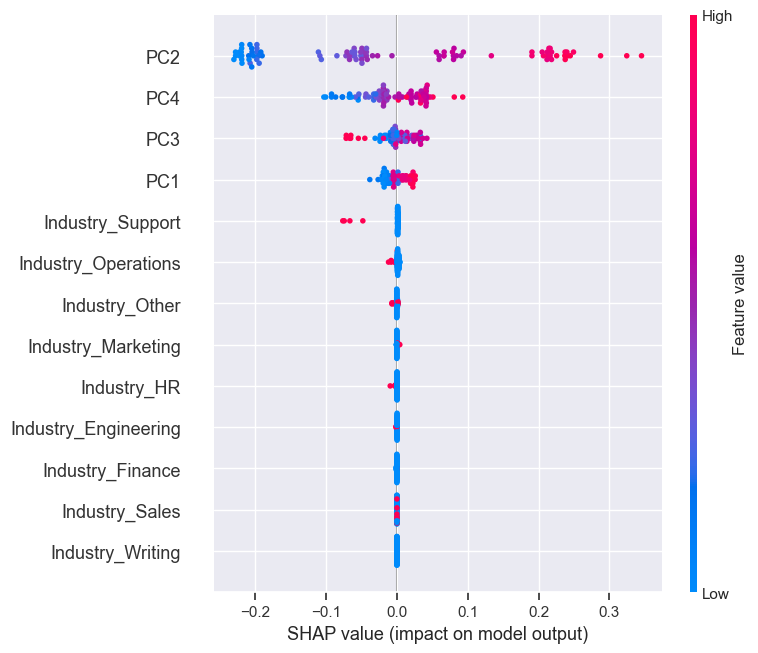

Top 5 features impacting salary prediction in XGBoost:
PC2: 0.14969246089458466
PC4: 0.03560631349682808
PC3: 0.017511023208498955
PC1: 0.013380518183112144
Industry_Support: 0.0040045795030891895


In [166]:
# Initialize the SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(best_models["XGBoost"])  # xgb_model is your trained XGBoost model
shap_values_xgb = explainer_xgb(X_test)  # X_test is your test dataset

# Summary Plot
shap.summary_plot(shap_values_xgb, X_test)

# Feature Importance (Mean Absolute SHAP values)
shap.importance_plot = shap_values_xgb.abs.mean(axis=0).values
feature_importance_xgb = dict(zip(X_test.columns, shap.importance_plot))
sorted_importance_xgb = sorted(feature_importance_xgb.items(), key=lambda x: x[1], reverse=True)

# Print top features
print("Top 5 features impacting salary prediction in XGBoost:")
for feature, importance in sorted_importance_xgb[:5]:
    print(f"{feature}: {importance}")

In [ ]:
# Save the trained model (e.g., XGBoost)
joblib.dump(best_models["XGBoost"], '..\\models\\salary_prediction_xgb.pkl')

['..\\fastAPI\\salary_prediction_xgb.pkl']